# Utvikling og påvirkning av multivalens i en- og flercellede systemer 


##### Simone Otelie Solstrand, Ine Zhao og Sigrid Saur Modahl
31. januar - 14. februar

### Sammendrag 

Vi analyserte først systemer bestående av enkeltelementer, monomerer. Vi plasserte monomerene tilfeldig på et tredimensjonalt gitter, ga de ladning og lot de flytte i forhold til hverandre. Energi, termiske fluktasjoner samt tilfeldigheter skulle påvirke resultatet. Vi analyserte til slutt grupperinger av monomerer med hensyn på ulike temperaturer.

Deretter gikk vi over til å analysere polymerer, mer kompliserte elementer. Polymerene skulle bestå av et visst antall monomerer og være av ulik form. Polymerene ble også tilfeldig plassert på et tredimensjonalt gitter, ble gitt ladning og de fikk ulike måter å flytte seg på. Først lot vi polymerene bevege seg som stive legemer, deretter mer fleksibelt, men kun om de alltid hang sammen. Også med polymerene skulle energi, termiske fluktasjoner og tilfeldigheter få påvirke sluttresultatet. Vi analyserte til slutt størrelse på grupperinger i forhold til størrelsen på polymerene samt antall grupperinger.


### Introduksjon 

I fysikken studerer vi ulike systemer som inneholder elementer som påvirker hverandre. Det kan være i stor skala med universet, stjerner og planeter og alt det inneholder. Et annet system kan være små organismer som celler, DNA og proteiner og alt annet en trenger for å ha en fungerende kropp. Et tredje system kan være dypere og ned på kvantenivå, og i kjemien er det atomer, molekyler og ioner som reagerer med hverandre og danner stoffer. Alle disse systemene er ikke så fryktelig ulike hverandre når vi tenker over det. De er alle bygd opp av elementer som har en påvirkning på hverandre, og kan endre seg til ulike sluttresultater ut fra ulike startbetingelser. Her ønsker vi derfor å simulere dette på en generell måte. Først med monomerer, et element bygd opp av kun 1 byggekloss, og deretter med polymerer, som er en sammensetning av monomerer. Videre plasseres disse i et system og deretter skal vi la de bevege seg og reagere med hverandre. Ulike startbetingelser, metoder og tilfeldigheter er med på å gi ulike resultater som gir rom for tolkning. 


### Teori 

Før vi begynner ønsker vi å introdusere teorien og formlene vi kommer til å bruke for å utvikle systemene våre.

Coulombs lov:
$$ E_{p} = \frac{q_{1} \cdot q_{2}}{4 \cdot \pi \cdot \epsilon_{0} \cdot \epsilon_{r} \cdot a^2} $$

Energi: 
$$ E = \sum_{i=0}^{n}E_{pi} $$

Termisk fluktasjon:
$$ random(0,1) < e^{\beta \cdot (E_{p} - E_{p0})} $$

Beta:
$$ \beta = \frac{1}{k_{b} \cdot T}$$


### Import

In [1]:
#Import av bibliotek for fungerende kode
%matplotlib inline
import numpy as np
import random as rd
import matplotlib.pyplot as plt


#Import av jit for å kjøre kode betydelig raskere
%pip install numba
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

#Fjerner noen warnings ved bruk av jit
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)


Note: you may need to restart the kernel to use updated packages.


# Monomerer

I første omgang ønsker vi å lage en simulasjon med monomerer og deres oppførsel. Vi kan se på monomerer som en-cellede organismer. I dette tilfellet har monomerene ladning, og vi kan tolke dem som ioner. Her studerer vi hvordan ulikt ladede monomerer reagerer med hverandre, men ulike startbetingelser. Hva skjer når vi plasserer monomerer med ulik ladning i et grid? Og hvordan kan temperatur påvirke systemet? 

For ordens skyld vil vi allerede nå informere om at griden vi jobber med virker 2D i plottene, men de er 3D fungerende. Sidekant til høyre og venstre er koblet, samt sidekantene oppe og nede. Totalt vil dette i 3D se ut som en torus mens i 2D virker det som alle hjørnene er langt unna hverandre, når de egentlig alle grenser til hverandre. 

Vi vil blant annet ta i bruk Monte Carlo algoritmen for å la monomerene flytte seg om det er energimessig gunstig, og registrere hvordan energien i griden endrer seg som resultat av flytting. Det er her temperatur kommer inn; for i Monte Carlo algoritmen så kan man tillate et flytt selv om det ikke er energimessig gunstig, men på grunnlag av at temperaturen er høy nok. Hvordan vil disse monomerene da flytte seg for ulike temperaturer og hvordan vil sluttresultatet se ut?


### Konstanter 

In [2]:
e_r = 78                                 #Relativ permativitet i vann
E0 = 8.854e-12                           #Vakuumpermativitet
a = 23e-6                                #Distanse mellom gridpunkter/lengde til monomer
e = 1.6e-19                              #Elementærladning
k_b = 1.380649e-23                       #Boltzmanns konstant 
alpha = (e**2)/(4*np.pi*E0*e_r*(a**2))   #Alpha, brukes i Coulombs lov


@jit(nopython=True)
def betaT(T):                            #Formel for å bruke på ulike temperaturverdier
    return 1/(k_b*T)


Vi definerer først alle konstantene som skal brukes i simulasjonene av monomerene. Alpha og alle konstantene den inneholder regner ut den potensielle energien mellom monomerer når de får kontakt med en annen monomer. Funksjonen beta(T) er med i utrykket for når et flytt er lovlig selv om det ikke er energimessig gunstig. Hensikten med beta(T) sin funksjon tydeliggjøres i Monte Carlo algoritmen.

### Variabler

In [3]:

N_s = 50000                             #N_s er antall flytt med monomerer
N = 15                                  #N er størrelsen i hver retning på grid, griden er NxN
M = 25                                  #M er antall monomerer som skal plasseres, M positive og M negative
T1 = 200                                #T1 er en relativt lav temperatur, oppgitt i Kelvin
T2 = 500                                #T2 er en relativt høy temperatur, oppgitt i Kelvin


Ovenfor definerer vi variablene som er ønskelige å bruke for kjøring av simulasjonene. I motsetning til konstantene kan disse variablene endres etter ønske, og kan da gi ulike resultater. Underveis har vi undersøkt mange ulike verdier for å analysere ulike resultater og kommet frem til disse gunstige verdiene. N_s gir oss nok flytt av monomerer for gode resultater. N og M gir en oversiktlig grid med nok, men ikke for mange, monomerer M av hver type. Sammen gir variablene oss interessante resultater ift. ulike temperaturer T1 og T2 som vi vil simulere senere.



### Lager system med monomerer

In [4]:

@jit(nopython=True)                                #Bruker jit foran funksjoner for å få ned kjøretiden
def MakeMeshgridMonomers(N,M): 
    grid = np.zeros((N, N), dtype=np.dtype('i2'))  #Lager et grid
                                   
    mono_count_neg = M             #For hver verdi M skal det plasseres M negative monomers i grid
    mono_count_pos = M             #For hver verdi M skal det plasseres M positive monomers i grid
    
    while mono_count_neg > 0:                                       #Så lenge det fortsatt er mer å plassere blir det gjort
        randnum_indexX_neg = np.random.randint(N)                   #Finner tilfeldig posisjon X
        randnum_indexY_neg = np.random.randint(N)                   #Finner tilfeldig posisjon Y

        if grid[randnum_indexX_neg, randnum_indexY_neg] != 0:       #Hvis illegalPlacement prøver vi igjen
            continue
        elif grid[randnum_indexX_neg, randnum_indexY_neg] == 0:     #Godkjent plassering
            randnum_mono_negative = np.random.randint(-10, -1)      #Tallverdi til negativ monomer
            grid[randnum_indexX_neg, randnum_indexY_neg] = randnum_mono_negative   #Legger random negativ verdi på plassen
            mono_count_neg -= 1                                     #Vil få oss ut av while når det er på tide, og er 
                                                                    #antall negative monomerer som gjenstår å plassere
    
    while mono_count_pos > 0:                                       #Så lenge det fortsatt er mer å plassere blir det gjort
        randnum_indexX_pos = np.random.randint(N)                   #Finner tilfeldig posisjon X
        randnum_indexY_pos = np.random.randint(N)                   #Finner tilfeldig posisjon Y

        if grid[randnum_indexX_pos, randnum_indexY_pos] != 0:       #Hvis illegalPlacement prøver vi igjen
            continue
        elif grid[randnum_indexX_pos, randnum_indexY_pos] == 0:     #Godkjent plassering
            randnum_mono_positive = np.random.randint(1, 10)        #Tallverdi til positiv monomer
            grid[randnum_indexX_pos, randnum_indexY_pos] = randnum_mono_positive   #Legger random positiv verdi på plassen
            mono_count_pos -= 1                                     #Vil få oss ut av while når det er på tide
        
    return grid                                                     #Returnerer griden med monomerer
 

Vi lager et gitter av størrelse NxN med grensebetingelser som gir det formen av en torus. Gitteret har 2*M monomerer tilfeldig plassert. Både N og M kan vi velge selv fra variablene våre i kodeblokken over. Det eneste å ta hensyn til på valg av N og M er at det må være plass til å plassere det vi ønsker, altså at $2 \cdot M < N^{2}$. Det er også hensiktsmessig å ha litt ekstra plass når vi senere skal la monomerene bevege seg. Utenom det vil koden ordne tilfeldig plassering selv. Frem til alle monomerene, både positive og negative, er plassert vil koden finne en tilfeldig plass til neste monomer. Monomeren vil så bli plassert her, men kun om plassen er ledig. Vi returnerer så det fullførte systemet.

### Plot av originalt system

Text(0.5, 1.0, 'System med 50 monomers')

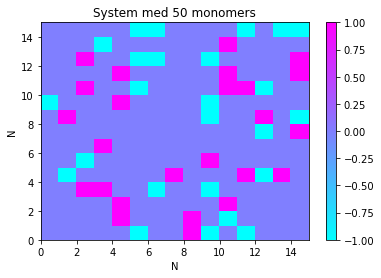

In [6]:

xv = MakeMeshgridMonomers(N,M)                                           #Henter ut et system med monomerer 

plt.figure(0)
plt.pcolormesh(xv[::-1,], cmap='cool', vmin=-1, vmax=1)                  #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"System med {2*M} monomers")                                  #Tittel for å informere om antall monomers


Her får vi visualisert systemet vi lagde ovenfor. Vi bruker grid[::-1,] fordi grid og plot fungerer ulikt i Python. Griden er bygd opp som en matrise og den har plass (0,0) øverst i venstre hjørne. Plottet derimot ønsker vi at har punkt (0,0) nederst i venstre hjørne, derav -1 for å snu det, fordi det er det vi er vant til med koordinatsystemer. Plottet viser oss tydelig 50 monomerer fordelt på en grid/torus som er NxN stor. Mellom monomerene er det ledige plasser med verdi 0. Halvparten av monomerene er negative, blå med verdi mellom -1 og -10, og andre halvpart er rosa med verdi mellom 1 og 10. Vi har begrenset fargene og verdiene til -1 og 1 på visualiseringen istedenfor sine respektive verdier mellom -10 og -1 samt 1 og 10. Dette gir en tydelig konstrast mellom hvilke monomerer som er negativt ladede og hvilke som er positivt ladede. I virkeligheten har de gjerne sterkere ladninger, men det er ikke nødvendig i visualiseringen her. Noe å ta med seg herfra er at de tydelig er tilfeldig plassert. Videre skal vi analysere utviklingen fra dette stadiet, og hvordan de vil flytte seg fra dette originale systemet ved ulike temperaturer.

### Naboer til en monomer

In [7]:

@jit(nopython=True)
def neighbour_coordinates(N, i, j):  
    y_opp = i + 1                       #i tilsvarer y-koordinaten og j tilsvarer x-koordinaten
    y_ned = i - 1                       #Lager variabler for å lettere holde oversikt
    x_venstre = j - 1                            
    x_hoyre = j + 1

    #Fikser verdiene for alle mulige grensetilfeller vegger (->donut/torus)
    if y_opp > (N-1):                                
        y_opp  = 0 
        y_ned = N-2  
    elif y_ned < 0:
        y_ned = N-1
        y_opp  = 1 
    if x_venstre < 0:
        x_venstre = N-1
        x_hoyre = 1
    elif x_hoyre > (N-1):
        x_hoyre = 0
        x_venstre = N-2
    
    #Naboene til en tilfeldig monomer, i rekkefølgen: høyre, venstre, opp og ned
    neighbours = np.array([(i, x_hoyre), (i, x_venstre), (y_opp ,j), (y_ned, j)], dtype=np.dtype('i2')) 
    return neighbours                  #Returnerer 4 elementer lang array
    

I flere problemstillinger er det er ønskelig å finne naboene til en monomer. Naboer er kun de koordinatene en monomer deler en hel sidekant med, ikke de plassene monomeren er i kontakt med i hjørnene sine. Plassen til monomeren er bestemt fra plasseringskoordinatene i og j. Om monomeren ikke befinner seg ved gitterets grenser er det lett å finne naboene ved å ta en kombinasjon av de originale koordinatene, og da legge til eller trekke fra 1 etter hvilken nabo man skal finne.  

Når en monomer befinner seg på en kant eller i et hjørne vil vårt generelle uttrykk forsøke å finne naboer utenfor gitterets grenser. Vi må manuelt ordne dette i og med at python ikke vet at vi ønsker gridet som en torus i 3D og ikke som 2D. Bruken av if/elif kommer fra grensetilfellene, og at alle naboene ikke kan være utenfor griden samtidig. Eksempelvis er at dersom monomeren befinner seg i øvre, høyre hjørne, så vil det være naboen over monomeren som havner utenfor griden. Dette vil da bli korrigert, og koden vil fortsette med å sjekke naboene til høyre og venstre. Den vil da finne at også høyre nabo er utenfor og korrigere denne. Monomeren kan altså få korrigert alle sine naboer manuelt ved denne metoden om den er i et hjørne eller på en sidekant!  Til slutt returnerer vi en array med nabokoordinatene i rekkefølge: høyre, venstre, opp og ned.


### Ladning og energi

In [8]:

@jit(nopython=True)   
def totalEnergy(grid, N):                                   #Regner ut energien i griden med monomerer
    energy = 0
    for r in range(N):
        for k in range(N):                                  #Itererer gjennom hver plass i griden
            if grid[r,k] != 0:                              #Hvis vi finner en monomer
                nabo = neighbour_coordinates(N, r, k)       #Henter naboene til monomeren
                for naboer in nabo:
                    pointCharge = grid[r,k]/abs(grid[r,k])  #Normaliserer originale energier til +-1
                    if grid[naboer[0],naboer[1]] != 0:      #Hvis en nabo også er en monomer
                      
                        neighbourPC = grid[naboer[0],naboer[1]]/abs(grid[naboer[0],naboer[1]])  
                                                                           #Normaliserer naboenergi til +-1
                        V = pointCharge * neighbourPC * alpha              #Coloumbs lov, energi mellom monomerene
                        energy += V                                        #Summerer energi mellom alle nabomonomerer
   
    return energy/2                              #For å unngå dobling av energi fordi alt multipliseres begge veier



Denne funksjonen finner den totale energien til systemet. Den fungerer slik at den itererer gjennom systemet for å finne en og en monomer. Deretter vil den finne naboene til monomeren. Dersom en av naboene også er en monomer, så vil det være potensiell energi mellom de to monomerene. Da normaliserer den ladningen til begge monomerene, og bruker coloumbs lov for å finne energien. Etter koden har iterert gjennom hele griden, så blir energien delt på to før den blir returnert. Dette gjør vi da funksjonen vil tillate potensial begge veier, og vi må dermed unngå å telle samme energi to ganger. 


In [9]:

energien = totalEnergy(xv, N)                                 #Kalkulasjon av energien til vårt originale system
print(f'Energien til vårt originale system blir {energien} Joule')


Energien til vårt originale system blir 2.788112626781279e-20 Joule


Her kalkulerer vi den totale energien til vårt originale system. Vi skal se utviklingen til denne energien etterhver som monomerene flytter seg. 

### Monte Carlo for system med monomerer

In [10]:

@jit(nopython=True)                              #Monte Carlo algoritme
def MC(grid, N, M, N_s, T):                      #Vi skal gradvis endre grid med monomerer ved bruk av energiverdier                                               
    
    newGrid = grid.copy()                        #For å unngå endring av originale grid må vi kopiere
    positions = np.argwhere(grid)                #Finner posisjonen til monomerene                               
    E_total = totalEnergy(grid, N)               #Henter ut total energi fra originale griden med monomerer

    epsilon = np.zeros(N_s+1)                    #Tom liste for å fylle med energier underveis i flyttingene
    epsilon[0] = E_total                         #Første element må være fra originale griden
    
    steps = 0                                    #Kontroll på whileløkka
    k = 1                                        #Hvilken plass energiverdien skal på i epsilon
    while (steps < N_s):                         #Skal gjennomføres like mange runder som Ns er valgt til
        
        random_num = np.random.randint(len(positions))      #Velger et random tall blant antallet monomerer vi har
        this_mono = positions[random_num]                   #Henter ut tilhørende monomer
        neighbours = neighbour_coordinates(N, this_mono[0], this_mono[1])   #Henter naboer til tilfeldig valgt monomer
        randnum_direction = np.random.randint(0, 3)         # 0 = høyre, 1 = venstre, 2 = opp, 3 = ned
        randdirection = neighbours[randnum_direction]       #Henter ut naboplassen i tilfeldig retning

        
        if grid[randdirection[0], randdirection[1]] == 0:   #Vi skal kun prøve å flytte om det er ledig plass
            newGrid = grid.copy()                           #For å unngå endring av originale grid må vi kopiere
            newGrid[randdirection[0], randdirection[1]] = grid[this_mono[0], this_mono[1]] 
                                                            #Den nye retningen får verdi av monomer, monomer flytter dit 
            newGrid[this_mono[0], this_mono[1]] = 0         #Den originale plassen blir 0 siden monomeren har flytta bort
            new_E_total= totalEnergy(newGrid, N)            #Ny total energi etter flytting av monomer
            
            p = np.random.random()                          #p blir er tilfeldig verdi mellom 0 og 1
            steps += 1                                      #Øker hver gang vi gjør et flytt slik at vi skal ha Ns flytt
        
            if new_E_total < E_total:         #Hvis flyttingen gir lavere energi er den tillatt griden blir den nye riktige
                grid = newGrid.copy()         #Nye griden blir den nye riktige fordi flytt var tillatt
                E_total = new_E_total         #Nye energien blir den nye riktige fordi flytt var tillatt
                
            elif p < np.exp(-betaT(T)*(new_E_total - E_total)):  
                                                            #Også en sannsynlighet for tillat flytting om dette er oppfylt
                grid = newGrid.copy()                       #Nye griden blir den nye riktige fordi flytt var tillatt
                E_total = new_E_total                       #Nye energien blir den nye riktige fordi flytt var tillatt
               
            epsilon[k] = E_total                            #Legger til energien i epsilon, skal senere plottes
            k += 1                                          #Vi går til neste plass i epsilon for å senere fylle der
            positions = np.argwhere(newGrid)                #Oppdaterer plassen til monomerene etter flytt
            
    return epsilon, grid                                    #Returnerer energiliste, ny Grid med endringer og gammel uten


I Monte Carlo skal vi endre vårt originale system ved å flytte monomerer. Vi kopierer vårt originale system for å ha et eksemplar av denne som ikke endres slik at vi kan endre den andre så mye vi vil uten å påvirke den originale. Vi finner posisjonene til alle monomerene og lager en liste, epsilon, som skal inneholde alle energiverdier for hvert delsteg av flyttingene. Vår første energi er selvsagt energien fra det originale systemet og deretter skal vi flytte N_s ganger. N_s er en valgfri variabel, men det er ønskelig at den er stor slik at monomerene får flyttet seg nok ganer til å muligens finne en stabil tilstand og plassering. 

Vi velger oss en tilfeldig monomer og finner dens naboer. Deretter skal vi igjen velge en tilfeldig retning denne kan prøve å flytte seg. Er det en ledig plass i denne retningen skal vi prøve å flytte, om ikke prøver vi igjen med ny monomer og ny retning. Var det ledig plass gjør vi flyttet og regner ut den nye energien for dette nye systemet. Om denne energiverdien lavere enn den forrige er flyttet gyldig og det nye systemet og energien gjøres til de riktige. 

Det er også unntak der et flytt er godkjent selv om den nye energien ikke er lavere enn forrige. Dette flyttet blir kun akseptert dersom et tilfeldig tall er mindre enn Boltzmann faktoren med hensyn på energidifferansen. Dermed vil høyere temperaturer gi en større sannsynlighet for et flytt selv om det ikke gir totalt lavere energi. Dette unntaket er grunnet termiske fluktuasjoner og er noe opp til tilfeldighetene, men er avhenger av temperaturen til systemet. Vi ønsker da å se hvordan temperatur kan påvirke hvordan systemet ender opp med å se ut til slutt. Når et flytt har vært gyldig blir den nye energien lagt til i epsilon og vi jobber videre med det nye systemet og de nye posisjonene til monomerene helt til N_s antall flytt er gjort.



### Monte Carlo resultater monomerer

In [103]:

epsilon, grid = MC(xv, N, M, N_s, T1)   #Henter ut energi, nytt system og originalt system fra Monte Carlo algoritmen

epsilon1, finalGrid1 = MC(xv, N, M, N_s, T1)                    #Henter ut fra MonteCarlo for T1=200K for plotting
epsilon2, finalGrid2 = MC(xv, N, M, N_s, T2)                    #Henter ut fra MonteCarlo for T2=500K for plotting

from tempfile import TemporaryFile              #Vi lagrer 
MCfil = TemporaryFile()                         #Oppretter en fil
np.savez(MCfil, finalGrid1)                           #Lagrer vårt nye system etter gjennomført Monte Carlo i filen
_ = MCfil.seek(0)                               #Åpner filen
npzfile = np.load(MCfil)                        #Laster inn filen
npzfile.files

#npzfile["arr_0"]              #første posisjonen i fila, blir plottet ved fjerning av #


['arr_0']

Monte Carlo fungerer som den skal så vi lagrer den i fil med np.savez for å kunne bruke senere igjen. Den lagrede versjonen er gjort med T1=200K temperaturen.

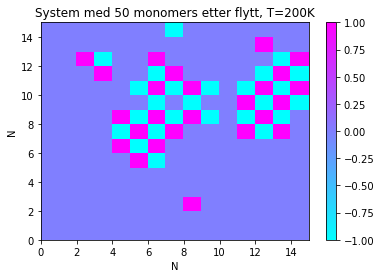

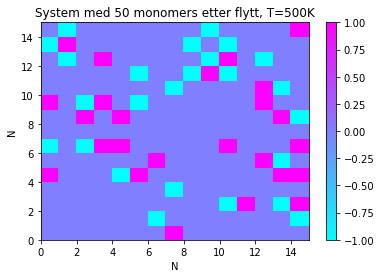

In [104]:

plt.figure(1)
plt.pcolormesh(finalGrid1[::-1,], cmap='cool', vmin=-1, vmax=1)     #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                      #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                     #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                     #Tydelig hvilken størrelse på grid (N)
plt.title(f"System med {2*M} monomers etter flytt, T={T1}K")        #Tittel for å informere om antall monomers
plt.show()

plt.figure(2)
plt.pcolormesh(finalGrid2[::-1,], cmap='cool', vmin=-1, vmax=1)     #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                      #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                     #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                     #Tydelig hvilken størrelse på grid (N)
plt.title(f"System med {2*M} monomers etter flytt, T={T2}K")        #Tittel for å informere om antall monomers
plt.show()


Vi kjører to simulasjoner og her ser vi svært tydelig først og fremst at lavere energi tilsvarer at en negativ og en positiv monomer kobler seg sammen. Monomerer av lik ladning vil ikke naturlig legge seg inntill hverandre siden + og + samt - og - vil gi en positiv energiverdi noe systemet ikke ønsker for stabilitet. Man ønsker lav og stabil energi. 

Ved lav temperatur T1 vil flyttene for det aller meste bestemmes av om energien blir lavere eller ikke og det vil gå mot samlinger av positive og negative monomerer der naboene alltid er av ulik ladning.

Ved høy temperatur T2 vil flyttene oftere bestemmes av vår tilfeldige parameter for godkjent flytt. Monomerene vil dermed flytte mindre systematisk og mer tilfeldig fordi det flyttes selv om det er energimessig ugunstig.

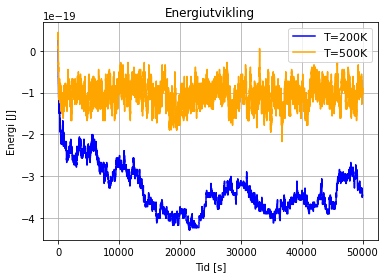

In [17]:

t = np.arange(0, len(epsilon1), 1)                             #Lager en tidsliste for plotting av energiutvikling

plt.figure(3)                                                  #Plotter energiutvikling opp mot hverandre for ulik T
plt.plot(t, epsilon1, label=f"T={T1}K", color="Blue")          #Plotter for T=200K
plt.plot(t, epsilon2, label=f"T={T2}K", color = "Orange")      #Plotter for T=500K
plt.title("Energiutvikling")                                   #Overskrift
plt.ylabel("Energi [J]")                                       #Navn på vertikal akse
plt.xlabel("Tid [s]")                                          #Navn på horisontal akse
plt.grid()                                                     #Lager rutenett i plottet
plt.legend(fontsize=11)                                        #For å se hvilken utvikling for hvilken temperatur
plt.show()


Vi ønsker nå å sammenligne energiutviklingene til monomerflyttingene for ulike temperaturer for å se hvor mye temperatur og termisk fluktasjon har å si. 
I figuren ser vi tydelig at ved gjennomsnittlig lavere temperaturer flytter monomerene seg når det er energimessig gunstig slik at energien jevnlig vil gå ned, og stagnerer når monomerene ikke har en bedre posisjon å flytte seg til. De vil da likevel bli flyttet når uttrykket med boltzmann faktoren er oppfylt, men vil så flytte mot lavere energi igjen senere ettersom det andre utrykket sjeldnere blir oppfylt ved lavere temperaturer. 

Høyere temperaturer vil derimot ha oftere godkjente flytt selv om det ikke er energimessig gunstig som følge av at det andre uttrykket oppfylles oftere, og dermed gir det ikke særlig utvikling av total energi i systemet. Det er mer lagt opp til tilfeldighetene og med store variasjoner.

Temperaturene brukt i disse simulasjonene er noe urealistiske fra et biologisk perspektiv, men de gir oss interessante resultater som vi ønsker å analysere uansett. T1 med 200 Kelvin tilsvarer -73 grader Celcius, det er 21 grader kaldere enn det noengang er målt til i Norge. Her analyserer vi dermed et system som kun er aktuelt på polene, men det er uansett interessant å se resultatene av denne temperaturen. I laboratorier har man gjerne mulighet til å manipulere initialtilstandene som f.eks. temperatur og dermed arbeide under de forholdene som vi her har analysert. Når det gjelder den andre temperaturen, T2, tilsvarer dette 227 grader Celcius. Dette er også svært mye høyere enn man normalt ville observert i naturen, men kan likevel være aktuell for å analysere systemer under ekstreme forhold. 

Tiden i vår visualisering av energiutviklingene tilsvarer antall Monte Carlo steg som er gjennomført. Når det kommer til en likevekt kan vi si at utviklingen med T=500K når sin likevekt ganske momentant og holder seg rundt -1e-19 Joule, men er i stadig endring rundt dette nivået. Det er ingen stabil likevekt og det er ingen lav energiverdi. t-equil, som er antall MC-steg som trengs for å nå likevekt, vil vi dermed anslå til å være 100.

Plottet for energiutviklingen ved T=200K nærmer seg en mye lavere energiverdi, mellom -3e-19 og -4e-19 joule, noe som er mer ønskelig for systemet. Derimot bruker den lengre tid på å nå dette energinivået og ved sammenligning av flere ulike systemer ser vi at den er garantert å komme ned på dette energinivået før det har gått 20 000 MC-steg. Vi bestemmer vår t_equil etter hvor energigrafen til T=200K når sitt første lokale energi minimalitet. Det varierer fra system til system hvor fort dette skjer, men er alltid før 20 000 steg av Monte Carlo algoritmen er gjennomført. 

t_equil er ulik for de to temperaturene fordi det er svært ulikt hvordan Monte Carlo algoritmen behandler de to systemene for ulike temperaturer. Det er disse to linjene i koden vår som utgjør forskjellen:

if new_E_total < E_total:

elif p < np.exp(-betaT(T)*(new_E_total - E_total)): 

Man ser altså at ved en høyere temperatur, T = 500 K, så vil det være større variasjoner grunnet termiske fluktuasjoner. Dermed vil det ikke være en like stor mulighet til å jevnlig gå mot et totalt lavere energinivå. Grunnet dette vil t_equil være lavere ved T = 500 K. Ved en lavere temperatur, T = 200 K, ser man at det er generelt mindre termiske fluktuasjoner, og de fleste flyttene er energimessig gunstige. Det tar da noe lengre tid før systemet når et lavt samt stabilt energinivå, og t_equil vil være større.


### Clusters

In [18]:

def monomerCoordinates(grid):
    newGrid = grid.copy()                                                   #Lager en kopi av grid
    monoCoordArr = np.argwhere(newGrid != 0)                                #Finner koordinatene til alle monomerer 
    return monoCoordArr

def setAllMonomerValues(grid, monoCoordArr):                                         
    nyGrid = grid.copy()                                                    #Lager en kopi av grid
    for m in range(len(monoCoordArr)):                                         
        nyGrid[monoCoordArr[m][0]][monoCoordArr[m][1]] = -1                 #Setter alle monomerer til -1 i den nye grid-en
    return nyGrid

monoCoordArr = monomerCoordinates(grid)                                       

def searchNeighbors(clusgrid,centerPoint, clusterValue):                    #Funksjon som skal finne naboer til et punkt
    clusgrid[centerPoint[0]][centerPoint[1]] = clusterValue                 #Setter hovedpunktet til å være lik polymerverdi
    centerNeighbors = neighbour_coordinates(N, centerPoint[0], centerPoint[1]) #Finner naboene til hovedpunktet
    length = len(centerNeighbors)                                           #Finner lengden for å bruke det i for løkken
    for d in range(length):
        if clusgrid[centerNeighbors[d][0]][centerNeighbors[d][1]] < 0:    #Dersom en nabo har negativ verdi (urørt monomer)
            searchNeighbors(clusgrid,centerNeighbors[d], clusterValue)    #så skal man lete etter naboene til denne naboen
    return clusgrid                                                       #og denne naboen blir "hovedpunkt", og rekursivt 
                                                                          #finner man alle naboene til naboene osv.
def Cluster(grid):
    monoCoordArr = monomerCoordinates(grid)                               #henter ut koordinatene til alle monomerer 
    numMonomers = len(monoCoordArr)                                       #Finner lengden for å bruke i for løkke
    generalMonoGrid = setAllMonomerValues(grid, monoCoordArr)             #Setter alle monomerverdier = -1
    ClusterGrid = generalMonoGrid.copy()                                  #Lager en kopi av grid med alle monomerer = -1
    clusterValue = 0                                                      #Verdi til polymer lages
    for m in range(numMonomers):
        centerPoint = monoCoordArr[m]                             #Setter hovedpunkt til å være m'te verdi av monomererarray
        if ClusterGrid[centerPoint[0]][centerPoint[1]] < 0:       #Dersom hovedpunkt er en monomer (forsikring)
            clusterValue += 1                                     #Så økes clusterverdi med 1, og 
            ClusterGrid = searchNeighbors(ClusterGrid,  centerPoint, clusterValue)   
                                                                  #henter ut griden vår fra den rekursive funksjonen
                                                                  #med den m'te monomeren som hovedpunkt. 
    return ClusterGrid


Vi bruker dataen fra kjøring av Monte Carlo med temperatur T1 til å lage clusters. En cluster er en samling av monomere der man har tilgang til hverandre via naboer. En enslig monomer blir da sin egen cluster. Vi lager dermed et nytt system der hver cluster skal inneholde monomere av lik verdi og dermed bli lik farge. Vi går gjennom hver monomer og sjekker alle naboer og sjekker naboene til naboene osv. helt til vi finner alle monomerene som tilhører en cluster og dermed tilegner disse monomerene lik verdi. Så går vi til neste monomer og om den allerede er blitt en del av en cluster går vi videre, om ikke gjør vi lik prosess. Enslige monomere får egen verdi og er sin egen cluster.


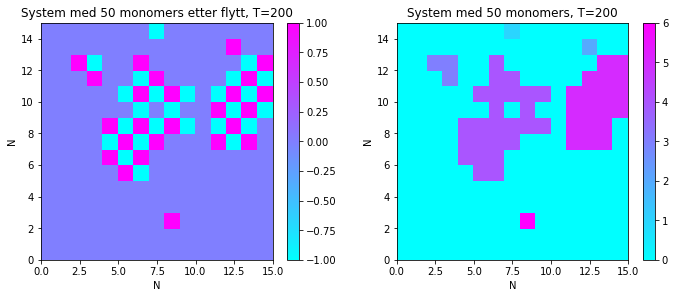

In [105]:

ClusterGrid = Cluster(finalGrid1)                                    #Henter ut verdier fra Clusterkode

gridFraFil = npzfile["arr_0"]                                        #første posisjonen i fila, originale systemet

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.pcolormesh(gridFraFil[::-1,], cmap='cool', vmin=-1, vmax=1)      #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                       #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                      #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                      #Tydelig hvilken størrelse på grid (N)
plt.title(f"System med {2*M} monomers etter flytt, T={T1}")          #Tittel for å informere om antall monomers
    
plt.subplot(1,2,2)
plt.pcolormesh(ClusterGrid[::-1,], cmap='cool')                      #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                       #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                      #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                      #Tydelig hvilken størrelse på grid (N)
plt.title(f"System med {2*M} monomers, T={T1}")
plt.tight_layout(2)
plt.show()

Vi visualiserer prosessen, og ser tydelig at alle monomerene i hver cluster får lik farge slik poenget var. Vi bruker temperatur T1 for å gjøre det mer interessant i og med at høyere temperaturer ikke ga noe særlig samlinger av monomere. Hver cluster inneholder monomerer av lik heltallsverdi. Vi plotter også det originale systemet som vi lagret i fil for å sammenligne. For å hente ut fra fil bruker vi kommandoen gridFraFil = npzfile["arr_0"] som henter det første elementet i lagret fil. Vi har kun lagret et system slik at vi vet det er vårt riktige system som blir hentet ut.

### Gjennomsnittlig clusterstørrelse

In [20]:

T_l = 100                            #Laveste temperaturen
T_h = 1000                           #Høyeste temperaturen
T_s = np.linspace(T_l, T_h, 10)      #Liste med 10 temperaturer mellom laveste og høyeste
t_max = 10000                        #Kan endres etter varighet på kjøring av koden, konstant som er med i T_equil formelen
s = 1/200                            #Konstant som er med i T_equil formelen
C = 10000                            #Konstant som er med i T_equil formelen
t_r = 1000                           #Antall tidsteg mellom hver måling
n = 25                               #Antall målinger gjort etter nådd likevekt i systemet


Vi definerer alle konstanter og verdier vi trenger til å finne clusterstørrelsen. T_max kan endres på etter varigheten til kjøringene av koden. n kan også endres på ved behov, men ellers er verdiene bestemte konstanter.

In [21]:

def T_equil(T):                                                #Funksjon som returnerer antall tidssteg før systemet når  
    return (t_max*np.e**(-s*(T-T_l)))+ C                       #likevekt. Likning fra oppgavetekster


@jit(nopython=True)
def Ns(T):                                                     #Funksjon som returnerer antall tidssteg i gitt temperatur T
    return (t_max*np.e**(-s*(T-T_l)))+ C + (t_r * n)           #Likning fra oppgavetekster


def find_clustersize(cluster, clus_val):                       #Funksjon som returnerer størrelsen på et cluster
    number = np.count_nonzero(cluster==clus_val)               #Numpy funksjon som teller antall hvor mange plasser 
    return number                                              #polymerverdien befinner seg 

def mean_clustersize(cluster):                                 #Finner gjennomsnittlig størrelse på cluster
    size = []                                                   
    antall = 0
    for i in range(len(cluster)**2):                           #For løkke som kjører gjennom hele systemet
        clus_size = find_clustersize(cluster, i)               #Finner størrelsen på et i'te cluster ved find_clustersize
        if clus_size != 0:                                     #Dersom størrelsen > 0, så blir d_len 1 større 
            antall += 1
        size.append(clus_size)                                 #legger til størrelsen på clusteret i den tomme listen
     
    d_sum = np.sum(size)                                       #Summerer deretter sammen alle størrelsene 
    d_mean = d_sum / antall                                    #Finner gjennomsnittet ved sum/antall
    
    antallClust = len(size)                                    #Antall clusters i et system
    return d_mean, antallClust


def Clustersize(xv, N, M, T_s):
    d = np.zeros(len(xv))                                      #Lager en tom array med samme lengde som grid
    antallClustPerT = np.zeros(len(xv))                        #Lager en tom array med samme lengde som grid
    
    for t in range(len(T_s)):                                  #For løkke som iterer gjennom lengden til T_s
        T_element = T_s[t]                                     #Setter T_element lik T_s av t'te tall fra løkken
        Eps, grid = MC(xv, N, M, N_s, T_element)           #Kjører T_element gjennom Monte Carlo
        cluster = Cluster(grid)                                #Finner alle clustere i grid
        d_mean, antallClust = mean_clustersize(cluster)        #Finner gjennomsnittelig størrelse på cluster
        d[t] = d_mean                                          #Sender gjennomsnittet i t'te plass til den tomme array
        antallClustPerT[t] = antallClust                       #Sender antall clusters i t'te plass til den tomme array
        
    
    d = d.ravel()[np.flatnonzero(d)]                                                 #Fjerner 0-ene i d
    antallClustPerT = antallClustPerT.ravel()[np.flatnonzero(antallClustPerT)]       #Fjerner 0-ene i antallClustPerT
    
    return d, antallClustPerT                                  #Returnerer midlere clusterstørrelser og antall clusters



Vi finner her størrelsen til hver cluster, altså hvor mange monomerer hver cluster inneholder. Deretter regner vi ut gjennomsnittstørrelsen slik at vi kan sjekke dette tallet for ulike temperaturer og se hvor mye temperatur har å si for grupperinger. Vi er også interesserte i å se ved hvilket temperaturområde denne endringen av resultater fra Monte Carlo algoritmen skjer i. 


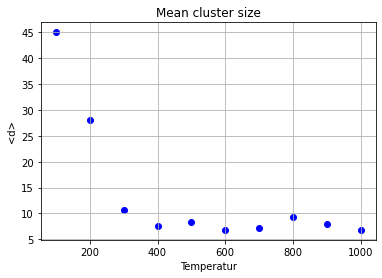

In [26]:

d, antallClustPerT = Clustersize(xv, N, M, T_s)                #Henter ut midlere clusterstørrelser og antall clusters

plt.figure(4)
plt.scatter(T_s, d, color="Blue")                              #Bruker scatterplot for å tydelig se punktresultater
plt.ylabel("<d>")                                              #Navn på vertikal akse
plt.xlabel("Temperatur")                                       #Navn på horisontal akse
plt.title("Mean cluster size")                                 #Tittel på plottet
plt.grid()                                                     #Gir rutenett på plottet, for å lettere se og analysere
plt.show()


Her ser vi svært tydelig at lave temperaturer skaper grupperinger med monomerer. Disse monomerene har skapt lavere total energi i systemet ved å gruppere seg systematisk sammen. På den andre siden gir høye temperaturer svært små grupperinger om det er grupperinger i det hele tatt siden de gjerne har muligheten til å flytte vekk fra stabile tilstander også. 

Midlere clusterstørrelse er større ved lavere temperaturer av samme grunn som t_equil er ulik ved ulike temperaturer. Temperaturen har mye å si for hvor stor andel kjøringen av koden er innom disse linjene:

if new_E_total < E_total:

elif p < np.exp(-betaT(T)*(new_E_total - E_total)): 

Ved lave temperaturer går den mye sjeldnere innom vår elif, mens ved økende temperaturer gjør den oftere det, og det vil gi mer unaturlige flyttinger av monomerer. Monomerene ved høye temperaturer får mulighet til å flytte bort fra hverandre slik at det ikke blir slike store ansamlinger som det blir ved lavere temperaturer. Ved lavere temperaturer blir gjerne flytt gjort kun om energien i systemet blir lavere og det skjer kun når en positiv og en negativ monomer legger seg ved siden av hverandre. Dette grunnet termiske fluktuasjoner. 

Dette skillet ligger for ulike resultater i forhold til temperatur ligger svært tydelig på rundt 200-300 Kelvin. Det innebærer jo 0 grader Celsius, som er på 273 Kelvin, noe som er svært interessant og gjør dette relevant for vår biologiske hverdag.

Vi valgte n for at Ns skulle bli rundt 50 000 fordi vi har arbeidet med denne verdien tidligere og vet at det blir nok flytt i Monte Carlo algoritmen til å nå en likevekt med dette. 

Det er både interessant og overraskende at ved 100 K vil så og si alle monomerene alltid ende i et cluster. Noe som også er overraskende er hvor raskt denne gjennomsnittlige størrelsen på clusters går ned ved høyere temperaturer. Allerede ved 400K blir det ingen store ansamlinger, gjerne bare mer tilfeldige grunnet de termiske fluktuasjonene.  



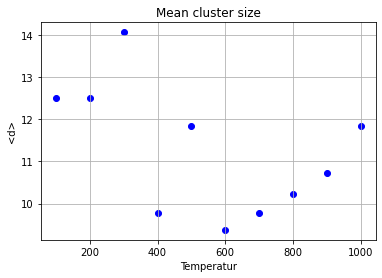

In [23]:

N_d2 = 25
M_d2 = 40 

d, antallClustPerT = Clustersize(xv, N_d2, M_d2, T_s)          #Henter ut midlere clusterstørrelser og antall clusters

plt.figure(5)
plt.scatter(T_s, d, color="Blue")                              #Bruker scatterplot for å tydelig se punktresultater
plt.ylabel("<d>")                                              #Navn på vertikal akse
plt.xlabel("Temperatur")                                       #Navn på horisontal akse
plt.title("Mean cluster size")                                 #Tittel på plottet
plt.grid()                                                     #Gir rutenett på plottet, for å lettere se og analysere
plt.show()


Vi valgte å plotte et nytt plott for å analysere dette for ulik initialbetingelse enn det forrige. Nå lagde vi et ganske mye større system og la inn færre monomerer ift. plasser enn tidligere. Da ser vi temperaturene ikke påvirker resultatet slik det gjorde på den forrige. På forrige var det en tydelig utvikling av nedgang, mens her er det noe mer tilfeldigheter. Selv om vi har 80 monomerer er det maks 15 som samler seg uansett temperatur, mens på forrige plott var det nesten alle. 


# Polymerer

Nå som vi har fått analysert monomerer har vi lyst til å gå et steg videre og se på polymerer. Polymerer er større og sammensatt av monomerer, altså kan vi tenke oss at de er som de clusterene vi fant ovenfor fra start. Vi har lyst til å lage simulasjoner av disse og deres oppførsel med hverandre. Polymerene vil også ha ulik ladning og mulighet til å reagere med hverandre, men det er større objekter å jobbe med enn monomerer. En monomer som skal flytte trenger bare tenke på seg selv, mens en polymer vil være av ulik størrelse og form og være mer avansert. Vi skal plassere et visst antall polymerer i et grid som igjen er en fungerende torus med kanter og hjørner som grenser til hverandre. Vi tar igjen i bruk Monte Carlo algoritmen for å la polymerene flytte på seg. Her også er disse flyttene basert på både energien til systemet, om denne nærmer seg en lavere og stabil verdi, samt at temperaturen og tilfeldigheter kan tillate andre flytt enn dette. Siden en polymer er ulik en monomer i forhold til størrelse og form kan et flytt skje på ulike måter. Vi kan la polymeren være et stivt objekt og alltid måtte flytte samlet eller vi kan la den være mer fleksibel. Vi begrenser oss til å prøve å flytte rad for rad eller kolonne for kolonne, altså ikke 100% fleksibelt. Risikoen her er at vi kan bryte opp polymeren i prosessen.


### Konstanter

In [27]:
e_r = 78                                   #Relativ permiativitet i vann
a2 = 91e-6                                 #Ny distanse mellom gridpunkter/lengde til delmonomerene i polymerene
alpha2 = (e**2)/(4*np.pi*E0*e_r*(a2**2))   #Ny alpha med den nye distansen, brukes i Coulombs lov


Vi definerer først alle konstantene vi skal bruke i simulasjonene av polymerene. Alpha og alle konstantene den inneholder vil la oss regne ut den potensielle energien mellom polymerer når de får kontakt. Flere av konstantene i alpha er allerede definert og brukt i monomeranalysen slik at vi slipper å skrive de opp igjen.

### Variabler

In [28]:
#Lage torus
Np = 25                 #Np er størrelsen i hver retning på grid, griden er Np x Np
Mp = 4                  #Mp er antall polymerer som skal plasseres, Mp positive og Mp negative
L = 20                  #L er størrelsen til hver polymer, hvor mange monomerer de skal inneholde

#Monte Carlo 
N_ss = 30000            #Antall kjøringer i Monte Carlo
T = 200                 #Temperatur


Her definerer vi variablene som er ønskelige å bruke for kjøring av simulasjonene.  I motsetning til konstantene kan disse variablene endres etter ønske, og kan da gi ulike resultater. Underveis i arbeidet har vi endret disse frem og tilbake for å analysere ulike resultater og kommet frem til at disse er de mest gunstige. Np gir en oversiktlig grid med nok plasser til å fylle vårt ønske av polymerer av en viss størrelse. Mp er antall positive polymerer samt antall negative polymerer. Hver polymer skal være av størrelse L, altså hvor mange monomerplasser den inneholder.


### Lager system med polymerer

In [29]:
 
def polymerCoordinates(polyGrid, polyValue):                 #Funksjon for å finne polymerkoordinater
    newPolyGrid = polyGrid.copy()                            #Lager en kopi for å ikke forstyrre den originale
    polyCoordArr = np.argwhere(newPolyGrid == polyValue)     #Finner koordinatene som har lik verdi, altså alle i en polymer
    return polyCoordArr

def polymerNeighbors(polyGrid, centerPoint, polyValue, L):   #Funksjon for å finne naboer
    polyGrid[centerPoint[0]][centerPoint[1]] = polyValue     #Vi tilegner et punkt i polygrid en verdi
    L -= 1                                                   #Reduseres med en hver gang et nytt punkt plasseres

    polyCoordArr = polymerCoordinates(polyGrid, polyValue)   #Henter ut alle koordinatene med lik verdi i polygrid

    stopper = 0                                              #Skal hindre oss fra å stå fast i while-løkken
  
    i = 1                                                    #i er en verdi fram til betingelsen oppfylles i while-løkka
    while i > 0:                      #while-løkken kjører fram til polymeren klarer å utvide seg i en tilfeldig retning
        stopper += 1
        randNum = np.random.randint(len(polyCoordArr))                              #Velger en tilfeldig plass av lik verdi
        centerPoint = polyCoordArr[randNum]                                         #Henter koordinatverdien
        centerNeighbors = neighbour_coordinates(Np, centerPoint[0], centerPoint[1]) #Finner naboene 
        r = np.random.randint(0, 3)                          #Velger tilfeldig retning for polymeret å utvide seg

        if polyGrid[centerNeighbors[r][0]][centerNeighbors[r][1]] == 0 and L > 0:   #Hvis det er ledig og vi skal plassere
            i = 0                     #Her oppfylles betingelsen, den finner en ny plass i grid å utvide polymer
            polyGrid, L = polymerNeighbors(polyGrid, centerNeighbors[r], polyValue, L)  #Finner naboene igjen
        elif  L == 0:                 #Har vi plassert det vi skal så går vi videre
            i = 0                     #her oppfylles betingelsen, L antall deler i polymeret er plassert i grid

        if stopper == 2000:           #Om vi har høy M og L ift N skal denne redde oss fra å stå fast og aldri få plassert
            break                     #Da går vi til neste og prøver igjen

    return polyGrid, L

def MakeMeshgridPolymers(Np,Mp,L):                           
    polyGrid = np.zeros((Np, Np), dtype=np.dtype('i2'))      #Lager et grid
    multivalency = L                                         #Lagrer L som en konstant

    randomNegativeValue = rd.sample(range(-10, -1), Mp)      #Velger en tilfeldig negativ verdi
    randomPositiveValue = rd.sample(range(1, 10), Mp)        #Velger en tilfeldig positiv verdi
    polyValue = np.concatenate((randomNegativeValue, randomPositiveValue), axis=None)    
                                                             #Samler våre tilfeldige verdier i array

    loop = 2*Mp                 #Vi skal lage 2*M polymerer, M positive og M negative, derav loope 2*Mp ganger
    p = 0                       #Antall polymerer vi har laget

    while loop > 0:             #Mens det fortsatt er polymere å lage
    
        randnum_indexX = np.random.randint(Np)                  #Finner en tilfeldig kolonne
        randnum_indexY = np.random.randint(Np)                  #Finner en tilfeldig rad
        centerPoint = [randnum_indexY, randnum_indexX]          #Lager punktet basert på de tilfeldige valgene
        if polyGrid[centerPoint[0], centerPoint[1]] == 0:       #Hvis plassen er ledig
            centerPointNeighbors = neighbour_coordinates(Np, centerPoint[0], centerPoint[1])  #Finner naboene til plassen
            #if len(np.argwhere(centerPointNeighbors)) > 0:      
            polyGrid, new_L = polymerNeighbors(polyGrid, centerPoint, polyValue[p], multivalency)  #Lager en polymer
            p += 1                                              #Oppdaterer antall polymerer laget
            loop -= 1                                           #Vi skal kjøre en mindre gang hver gang en polymer er lagd

    polymerSize = np.zeros(len(polyValue))          #Lager en liste med størrelser på polymerer
    for i in range(len(polyValue)):                 #For vår egen del
        polymerSize[i] = (find_clustersize(polyGrid, polyValue[i]))   
                                                    #Finner størrelse på clusters altså polymerene, de skal alle være L

    return polyGrid


Vi lager et system av størrelse Np x Np med $2 \cdot M$ polymerer av størrelse L, plassert tilfeldig. Både, N, M og L kan vi velge selv fra variablene våre i kodeblokken ovenfor. Det man burde ta hensyn til ved valg av disse er at det må være plass til å plassere det vi ønsker. M polymerer av størrelse L tar opp mange flere plasser enn M monomerer gjør. For å la polymerene ha en mulighet til å flytte seg blir dette veldig begrenset dersom de er samlet på liten plass, mens mulighetene vil være flere ved større system. Vi bør heller ikke ha for stort system, vi må la polymerene ha mulighet til å finne hverandre også. 

Koden velger ut en tilfeldig plass for hver polymer og lager deretter polymeren rundt denne i et system. For hver nye plassering, ønsker vi heller å bygge den på ut fra et tilfeldig sted på polymeren enn fra forrige plassering. Dette hjelper oss til å lage klyngete polymerer istedenfor lange slanger. Vi har også tatt hensyn til, og unngått, at en polymer skal kunne låse seg fast mellom de som er laget tidligere og ikke bli så stor som den skal. Polymerene blir formet tilfeldig samt etter hvor det er ledige plasser. Til slutt har vi et komplett system med våre ønsker om størrelse, antall polymere og størrelse på disse i tilfeldige former. 


### Polymersystem

Text(0.5, 1.0, 'System med 8 polymers av størrelse 20')

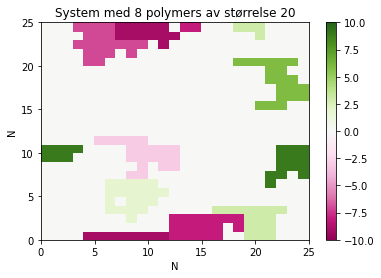

In [36]:

polygrid = MakeMeshgridPolymers(Np, Mp, L)                               #Henter ut systemet med polymere for plotting

plt.figure(6)
plt.pcolormesh(polygrid[::-1,], cmap='PiYG', vmin=-10, vmax=10)          #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"System med {2*Mp} polymers av størrelse {L}")                #Tittel for plottet



Her får vi visualisert systemet vi lagde ovenfor. Vi bruker grid[::-1,] igjen, med lik begrunnelse som de andre plottene. Grid/matriser og plot i python er ulikt organisert.

Plottet viser oss tydelig $2 \cdot M$ polymerer av størrelse L fordelt på et system som er NxN stort. Mellom polymerene er det ledige plasser med verdi 0. Polymerene er tydelig helt tilfeldig plassert og av tilfeldig form. Halvparten av polymerene er negative med varierende verdier mellom -1 og -10. Den andre halvparten er positive med tilfeldige verdier mellom 1 og 10. Her har vi valgt å visualisere polymerene med ulike verdier og farger for å lettere se de ulike om de grenser til hverandre. Omgjørelsen til verdiene -1 og 1 gjøres i energievalueringen nedenfor. 

Dette blir vårt originale system og så skal vi analysere utviklingen fra dette stadiet etter hvert som vi lar polymerene flytte seg. Vi skal analysere ulike måter å flytte seg på så resultatene vil kunne bli ulike fra denne originale. Hvordan vil ulike flyttemetoder og temperatur påvirke systemets oppsett?


### Systemets energi med polymerer

In [32]:

@jit(nopython=True)
def totalEnergyPolymer(polymerGrid):
    energy = 0                                                               #Lager energi variabel

    for r in range(N):                                                       #Lager to for løkker for å iterere gjennom grid
        for k in range(N):
            if polymerGrid[r,k] != 0:                                        #Dersom punktet er en monomer, så 
                neighbour = neighbour_coordinates(N, r, k)                   #Finner vi naboene
                for naboer in neighbour:                                     #Og for hver nabo finner vi verdiens dens 
                    neighbour_point = polymerGrid[naboer[0],naboer[1]]
                    if neighbour_point != 0 and neighbour_point != polymerGrid[r,k]:  
                                                #Dersom verdien ikke er 0 og ikke er den samme som verdien til hovedpunktet
                                                #Altså, så lenge vi grenser til en ny polymer
                        ourEnergy = polymerGrid[r,k]/abs(polymerGrid[r,k])    
                        theirEnergy = neighbour_point/abs(neighbour_point)   #Så normaliseres energiene
                        
                        V = ourEnergy * theirEnergy * alpha2                #Vi bruker coloumbs lov
                        energy += V                                         #Og legger til delenergien til total torusEnergi
    
    return energy/2                                                         #Deler på 2 for å unngå dobbel "telling"


For analyse av energien gjør vi samme prosess som med monomerer, men med et unntak. Monomerene som er elementer i den samme polymeren og er naboer skal ikke ha noe potensial mellom seg. Dermed må vi sjekke for hver monomer om naboen ved siden av seg har ulik verdi eller ikke. Kun når de er monomerer i ulike polymerer skal de kunne bidra med en energiverdi til systemet. Denne prosessen gjøres over hele systemet og til slutt deler vi på 2 for å unngå dobling av energi fordi funksjonen vil tillate potensial begge veier på naboer. 


### Polymerflytt stivt legeme

In [34]:

def rigid_move(polymer, direction, polymerGrid, N):   
    hvor = np.argwhere(polymerGrid == polymer)         #lager en liste med hvor monomerene er 
    movedGrid = polymerGrid.copy()              #lager en kopi av polymerGrid slik at vi kan flytte polymerene i kopien
    m = 0
    ig = 0
    sjekk = np.zeros((len(hvor),2))
    igjen = np.zeros((len(hvor),2))
    sjekk.fill(N + 1)
    igjen.fill(N + 1)
   

   
    #sjekker om det er et lovlig flytt
    for t in range(len(hvor)):
        neighbour = neighbour_coordinates(N,hvor[t][0],hvor[t][1])    
                                                                    #naboer til m'te monomeren i polymer
        neighbour_value_direction = polymerGrid[neighbour[direction][0],neighbour[direction][1]] 
                                                                    #Sjekker verdien til naboen i ønsket flytteretning
       
        if neighbour_value_direction != 0 and neighbour_value_direction != polymer: 
                                                                    #Dersom verdien ikke er 0 og ikke lik polymerverdien, 
            return movedGrid                                        #så kan man ikke gjennomføre flyttet
    
    #Gjør selve flyttet 

    if direction == 0 or direction == 2:   #Dersom ønsket flytt er høyre eller ned, så må [hvor] reverseres
        flipp = hvor[::-1]                 #reverserer hvor 
        for monomer in flipp:              #Itererer gjennom hver monomer i den reverserte arrayen 
            videre = 0
            for i in range(len(sjekk)):
                if sjekk[i][0] == monomer[0] and sjekk[i][1] == monomer[1]:
                    videre = 1       
            if videre == 1:
                continue
                
            if direction == 0:             #Dersom ønsket flytt er til høyre
                
                monomer_neighbour = neighbour_coordinates(N,monomer[0],monomer[1]) #Henter nabo til høyre for monomer
                new_x_monomer = monomer_neighbour[0][1]                            #Henter ny x-koordinat fra naboen
                newnew = neighbour_coordinates(N, monomer_neighbour[0][0], monomer_neighbour[0][1])
                
                if movedGrid[monomer[0], new_x_monomer] == polymer:
                    if movedGrid[monomer[0], newnew[0][1]] == polymer:
                        igjen[ig] = [monomer[0], newnew[0][1]]
                        
                        ig += 1
    
                if movedGrid[monomer[0], new_x_monomer] == polymer:
                    movedGrid[monomer[0], monomer[1]] = 0  
                    
                    movedGrid[monomer[0], newnew[0][1]] = movedGrid[monomer[0], new_x_monomer]
                    sjekk[m] = [monomer[0], new_x_monomer]
                    m += 1 
                    
                      
                else:    
                    movedGrid[monomer[0], new_x_monomer] = polymer 
                                                                #flytter monomer til ny posisjon med tilegnet polymerverdi
                    movedGrid[monomer[0], monomer[1]] = 0       #Setter gammel posisjon lik 0
                
            if direction == 2:                                  #Dersom ønsket flytt er ned 
               
            
                monomer_neighbour = neighbour_coordinates(N,monomer[0],monomer[1]) #Henter nabo nedenfor monomer
            
                new_y_monomer = monomer_neighbour[2][0]                            #Henter ny y-koordinat fra naboen
                
                newnew = neighbour_coordinates(N, monomer_neighbour[2][0], monomer_neighbour[2][1])
    
                if movedGrid[new_y_monomer, monomer[1]] == polymer:
                    if movedGrid[newnew[2][0],monomer[1]] == polymer:
                        igjen[ig] = [newnew[2][0],monomer[1]]
                        ig += 1
                       
                        
                if movedGrid[new_y_monomer, monomer[1]] == polymer:
                    movedGrid[monomer[0], monomer[1]] = 0  

                    movedGrid[newnew[2][0], monomer[1]] = movedGrid[new_y_monomer, monomer[1]]
                    sjekk[m] = [new_y_monomer, monomer[1]]
                    m += 1  
                    
                   
                else:
                    movedGrid[new_y_monomer, monomer[1]] = polymer      #flytter til ny posisjon med tilegnet polymerverdi
                
                    movedGrid[monomer[0], monomer[1]] = 0 
                

        if ig > 0:
            new_igjen = igjen[~np.all(igjen == N + 1, axis=1)]
            
            for i in new_igjen: 
                movedGrid[int(i[0]),int(i[1])] = polymer   
            

    else:
        for monomer in hvor:              #Dersom retningen er venstre eller opp, så skal man ikke reversere [hvor]
            videre = 0
            for i in range(len(sjekk)):
                if sjekk[i][0] == monomer[0] and sjekk[i][1] == monomer[1]:
                    videre = 1       
            if videre == 1:
                continue
                 
            if direction == 1:            #Dersom ønsket flytt er til venstre        
                monomer_neighbour = neighbour_coordinates(N,monomer[0],monomer[1]) #Henter nabo til venstre for monomer
                new_x_monomer = monomer_neighbour[1][1]                            #Henter ny x-koordinat fra naboen
                newnew = neighbour_coordinates(N, monomer_neighbour[1][0], monomer_neighbour[1][1])
               
                if movedGrid[monomer[0], new_x_monomer] == polymer:
                    if movedGrid[monomer[0], newnew[1][1]] == polymer:
                        igjen[ig] = [monomer[0], newnew[1][1]]
                        ig += 1
                        
    
                if movedGrid[monomer[0], new_x_monomer] == polymer:
                    movedGrid[monomer[0], monomer[1]] = 0  
                    
                    movedGrid[monomer[0], newnew[1][1]] = movedGrid[monomer[0], new_x_monomer]
                    sjekk[m] = [monomer[0], new_x_monomer]
                    m += 1 
                
                else:
                    movedGrid[monomer[0], new_x_monomer] = polymer                     
                                                                #flytter monomer til ny posisjon med tilegnet polymerverdi
                    movedGrid[monomer[0], monomer[1]] = 0       #Setter gammel posisjon lik 0
                
                
                
            if direction == 3:            #Dersom ønsket flytt er oppover?
                monomer_neighbour = neighbour_coordinates(N,monomer[0],monomer[1]) #Henter nabo ovenfor monomer 
                new_y_monomer = monomer_neighbour[3][0]                            #Henter ny y-koordinat fra naboen
                newnew = neighbour_coordinates(N, monomer_neighbour[3][0], monomer_neighbour[3][1])
                 
                if movedGrid[new_y_monomer, monomer[1]] == polymer: 
                     if movedGrid[newnew[3][0],monomer[1]] == polymer:
                        igjen[ig] = [newnew[3][0],monomer[1]]
                        ig += 1
                if movedGrid[new_y_monomer, monomer[1]] == polymer:         
                    movedGrid[monomer[0], monomer[1]] = 0  
                    movedGrid[newnew[3][0], monomer[1]] = movedGrid[new_y_monomer, monomer[1]]
                    sjekk[m] = [new_y_monomer, monomer[1]]
                    m += 1 
                    
                else:
                    movedGrid[new_y_monomer, monomer[1]] = polymer          
                                                                #Flytter monomer til ny posisjon med tilegnet polymerverdi
                    movedGrid[monomer[0], monomer[1]] = 0       #Setter gammel posisjon lik 0
 
        if ig > 0:
              
            new_igjen = igjen[~np.all(igjen == N+1, axis=1)]
           
            for i in new_igjen: 
                movedGrid[int(i[0]),int(i[1])] = polymer   
   
    return movedGrid

Nå ønsker vi å definere hvordan en polymer skal få lov til å flytte seg om vi anser den som et stivt legeme. Vi velger hvilken polymer vi vil forsøke å flytte samt hvilken retning vi ønsker å flytte den. Deretter lar vi koden vår sjekke om dette er et godkjent flytt. Et flytt er kun godkjent om hele polymeren i sin helhet kan flytte i gitt retning. Er den blokkert av noe, noe som helst sted på polymeren, vil ikke flyttet være gyldig og vi går tilbake til systemet før forsøkt flytt.

Er det derimot ledig i gitt retning for at hele polymeren får flyttet seg lar vi den gjøre det. Grunnet ulikt system på grid og plot i Python må vi tidvis reversere arrayen som inneholder posisjonene til monomerene. Dette trengs når vi ønsker et flytt til høyre eller ned. Vi tar også hensyn til grensetilfeller en polymer kan oppleve slik at den alltid vil flytte i sin helhet som et stivt legeme.


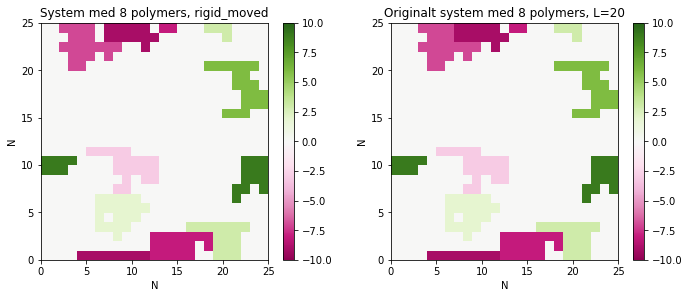

In [39]:

movedGridSL = rigid_move(-7, 1, polygrid, Np)                            #Henter ut system med stivt legeme flytting

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.pcolormesh(movedGridSL[::-1,], cmap='PiYG', vmin=-10, vmax=10)       #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"System med {2*Mp} polymers, rigid_moved")


plt.subplot(1,2,2)
plt.pcolormesh(polygrid[::-1,], cmap='PiYG', vmin=-10, vmax=10)          #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"Originalt system med {2*Mp} polymers, L={L}")
plt.tight_layout(2)
plt.show()


Vi kjører to simulasjoner for å analysere differansen mellom dem. Den ene simulasjonen er det originale systemet vi fant tidligere, mens det andre er systemet etter et godkjent flytt. Vi ser tydelig at vår valgte polymer (rosa øverst til venstre) har flyttet som et stivt legeme i den retningen vi ønsket. Utenom denne er systemet slik den originale som den skal. Vi kan da bruke denne koden i Monte Carlo algoritmen og la det skje flere flyttinger. Igjen skal flyttene være basert på endring i energi i systemet eller temperaturen til systemet. 

### Monte Carlo for polymerer

In [40]:

def MC_poly_rigid(grid, N, M, L, N_s, T):                  #Grid må være med polymerer 

    oldgrid = grid.copy()                                  #Kopi av grid for å hindre endring av originale

    E_total = totalEnergyPolymer(grid)                     #Henter ut total energi til grid

    epsilon = np.zeros(N_s + 1)                            #Lager en tom array som skal fylles med energiverdier
    epsilon[0] = E_total                                   #Første element skal være gridens startenergi

    steps = 0                                              #Bruker antall steg for å stoppe while-løkke
    k = 1                                                  #k'te element i epsilon
    
    newGrid = grid.copy()                                  #Kopierer grid slik at alle flytt skjer i kopien

    while (steps < N_s):                                   #While-løkke som stopper når vi når antall steg
        positions = np.argwhere(newGrid)                   #Finner posisjon til monomerer i polymerer
        random = np.random.randint(len(positions))         
        the_one = positions[random]                        #Velger en av posisjonene
        polymer = grid[the_one[0], the_one[1]]             #Henter verdien i posisjonen
         
        random_direction = np.random.randint(0,3)          #Velger en tilfeldig retning
    
        newGrid = rigid_move(polymer, random_direction, newGrid, N)

        p = np.random.random()                             #Tilfeldig verdi mellom 0 og 1
        steps += 1                                         
       
        new_E_total = totalEnergyPolymer(newGrid)          #Finner energien
        
        if new_E_total < E_total:           #Hvis flyttingen gir lavere energi er den tillatt og griden blir den nye riktige
            grid = newGrid.copy()
            E_total = new_E_total
                    
        elif p < np.exp(-betaT(T)*(new_E_total - E_total)):  #Også en sannsynlighet for tillat flytting om dette er oppfylt
            grid = newGrid.copy()
            E_total = new_E_total
                
        epsilon[k] = E_total                               #Legger til et energielement i epsilon
        k += 1                                             #Går til neste plass i epsilon
            
    return epsilon, grid, newGrid                 



I Monte Carlo algoritmen skal vi endre vårt originale system ved å flytte polymerer. Vi kopierer vårt originale system for å ha et eksemplar av denne som ikke endres og så kan vi endre den andre så mye vi vil uten å påvirke den originale. Vi lager en liste, epsilon, som skal inneholde alle energiverdier for hvert delsteg av flyttingene. Vår første energi er energien fra det originale systemet og så skal vi flytte N_ss ganger. N_ss er en valgfri variabel, men det er ønskelig at den er stor slik at polymerene får flyttet seg nok ganger til å muligens finne en stabil tilstand og plassering. 

Vi finner alle posisjonene til polymerene og velger en tilfeldig av disse som vi skal prøve å flytte en tilfeldig retning. Hvis vi ønsker å flytte polymeren som et stivt legeme forsøker den å gjøre dette ved metoden vi lagde tidligere. Senere skal vi se på en annen måte å kunne flytte en polymer på slik at vi har laget denne koden generell. Var det ledig plass til hele polymeren i den tilfeldige retningen gjøres flyttet og vi regner ut den nye energien for dette nye systemet. Om denne energiverdien lavere enn den forrige er flyttet gyldig og det nye systemet og energien gjøres til de riktige. 

Det er også et unntak der et flytt er godkjent selv om den nye energien ikke er lavere enn forrige. Dette flyttet blir kun akseptert dersom et tilfeldig tall er mindre enn Boltzmann faktoren med hensyn på energidifferansen. Dermed vil høyere temperaturer gi en større sannsynlighet for et flytt selv om det ikke gir totalt lavere energi. Dette unntaket er grunnet termiske fluktuasjoner og er noe opp til tilfeldighetene, men avhenger av temperaturen til systemet. Vi ønsker da å se hvordan temperatur kan påvirke hvordan systemet ender opp med å se ut til slutt. Når et flytt har vært gyldig blir den nye energien lagt til i epsilon. Vi velger oss ut en ny tilfeldig polymer for å prøve å flytte denne og repeterer hele prosessen til N_ss forsøk på flytt er gjennomført.


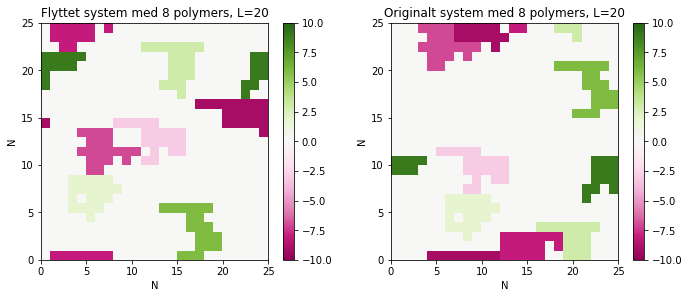

In [41]:

epsilonPoly, gridPoly, newGridPoly = MC_poly_rigid(polygrid, Np, Mp, L, N_ss, T)   #Henter verdier fra Monte Carlo

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.pcolormesh(newGridPoly[::-1,], cmap='PiYG', vmin=-10, vmax=10)       #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"Flyttet system med {2*Mp} polymers, L={L}")

plt.subplot(1,2,2)
plt.pcolormesh(polygrid[::-1,], cmap='PiYG', vmin=-10, vmax=10)      #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"Originalt system med {2*Mp} polymers, L={L}")
plt.tight_layout(2)
plt.show()


Vi kjører to simulasjoner for å analysere differansen mellom dem. Den ene simulasjonen er det originale systemet vi fant tidligere, mens det andre er systemet etter gjennomførelse av Monte Carlo algoritmen. Vi ser tydelig at polymerene våre har flyttet som stive legemer i tilfeldige retninger mange ganger. Det har ikke skjedd noen brudd eller endring av formen eller verdiene til polymerene av noen grad! 

Kjøretiden for Monte Carlo med rigid_move, altså med flytt som om polymerene er stive legemer, er svært mye kortere enn med monomerer. Dette merker vi spesielt fordi vi ikke trenger å bruke jit på polymerer, mens med monomerer tok det altfor lang tid om vi ikke hadde det med. Grunnen til den ulike kjøretiden har med antall polymerer og operasjoner å gjøre. I systemet med polymerer er det færre valg og operasjoner. Vi har et system som består av færre deler, 8 istedenfor 50, og vi kan ofte oppleve at et flytt ikke er godkjent. 


### Polymerflytt rader eller kolonner

In [42]:
def medNeighborCoord(row, val, direction):                                  #Lager funksjon for å hente ut riktig punkt
    if direction == 0:                                                      #Punkt avgjøres etter valg av retning 
        point = [row, val+1]
    elif direction == 1:
        point = [row, val-1]
    elif direction == 2: #ned
         point = [row+1, val]
    elif direction == 3: #opp
        point = [row-1, val]
    return point

def checkLegitMove(polygrid, polyval, monorow, direction, Np, r_or_k):      #Er flyttet godkjent?
    newGrid = polygrid.copy()

    if r_or_k == 'r' and direction == 0:                                    #Hvis vi skal flytte rader til høyre
        for i in range(Np):
            if newGrid[monorow, -i] == polyval: #flipper her med i
                pNDir = medNeighborCoord(monorow, -i, direction)
                if (newGrid[pNDir[0]][pNDir[1]] != 0 and newGrid[pNDir[0]][pNDir[1]] != polyval): 
                                                                            #annen polymer ved siden av
                    break

                elif newGrid[pNDir[0]][pNDir[1]] == 0:                      #Ledig plass ved siden av
                    newGrid[pNDir[0]][pNDir[1]] = polyval
                    if i < Np-1:
                        newGrid[monorow, -i] = 0
 
                elif newGrid[pNDir[0]][pNDir[1]] == polyval:                #Egen polymerverdi ved siden av
                    newGrid[monorow, -i] = 0

    if r_or_k == 'r' and direction == 1:                                    #Hvis vi skal flytte rader til venstre
        for i in range(Np): #-Np//2,Np-(Np//2)
            if newGrid[monorow, i] == polyval: 
                pNDir = medNeighborCoord(monorow, i, direction)
                if (newGrid[pNDir[0]][pNDir[1]] != 0 and newGrid[pNDir[0]][pNDir[1]] != polyval): 
                                                                            #annen polymer ved siden av
                    break                    
                elif newGrid[pNDir[0]][pNDir[1]] == 0:                      #Ledig plass ved siden av
                    newGrid[pNDir[0]][pNDir[1]] = polyval
                    if i < Np-1: #Np-(Np//2
                        newGrid[monorow, i] = 0

                elif newGrid[pNDir[0]][pNDir[1]] == polyval:                #Egen polymerverdi ved siden av
                    newGrid[monorow, i] = 0

    if r_or_k == 'k' and direction == 2:                                    #HVis vi skal flytte kolonner ned
        for i in range(Np):
            if newGrid[-i, monorow] == polyval: #flipper her med i
                pNDir = medNeighborCoord(-i, monorow, direction)
                if (newGrid[pNDir[0]][pNDir[1]] != 0 and newGrid[pNDir[0]][pNDir[1]] != polyval): 
                                                                            #annen polymer ved siden av
                    break
                elif newGrid[pNDir[0]][pNDir[1]] == 0:                      #Ledig plass ved siden av
                    newGrid[pNDir[0]][pNDir[1]] = polyval
                    if i < Np-1:
                        newGrid[-i, monorow] = 0
                    
                elif newGrid[pNDir[0]][pNDir[1]] == polyval:                #Egen polymerverdi ved siden av
                    newGrid[-i, monorow] = 0


    if r_or_k == 'k' and direction == 3:                                    #Hvis vi skal flytte kolonner opp
        for i in range(Np):
            if newGrid[i, monorow] == polyval: 
                pNDir = medNeighborCoord(i, monorow,direction)
                if (newGrid[pNDir[0]][pNDir[1]] != 0 and newGrid[pNDir[0]][pNDir[1]] != polyval): 
                                                                            #annen polymer ved siden av
                    break                 
                elif newGrid[pNDir[0]][pNDir[1]] == 0:                      #Ledig plass ved siden av
                    newGrid[pNDir[0]][pNDir[1]] = polyval
                    if i < Np-1:
                        newGrid[i, monorow] = 0

                elif newGrid[pNDir[0]][pNDir[1]] == polyval:                #Egen polymerverdi ved siden av
                    newGrid[i , monorow] = 0

    return newGrid

def medFlex(polygrid, polyval, direction, Np , r_or_k):                     #Hovedfunksjon for medium_flex flytt
    mediumGrid = polygrid.copy()
    #lst = np.zeros(len(np.argwhere(polygrid)))
    if r_or_k == 'r' and (direction == 0 or direction == 1):                #Flytte rader, til høyre eller venstre
        for monorow in range(Np):
            mediumGrid = checkLegitMove(mediumGrid, polyval, monorow, direction, Np, r_or_k)

    elif r_or_k == 'k' and (direction == 2 or direction == 3):              #Flytte kolonner, ned eller opp
        for monocol in range(Np):
            mediumGrid = checkLegitMove(mediumGrid, polyval, monocol, direction, Np, r_or_k)


    return mediumGrid



Nå ønsker vi å definere hvordan en polymer skal få lov til å flytte seg om det er noe mer fleksibelt enn et stivt legeme. Vi velger hvilken polymer vi vil forsøke å flytte samt hvilken retning vil ønsker å flytte den. I tillegg til dette velger vi om vi ønsker å flytte rader eller kolonner. Valget av dette vil gi oss flere muligheter til godkjente flyttinger. Nå vil et flytt kunne være godkjent for hver rad eller hver kolonne, noe som skiller seg fra vår andre mulighet for flytting. 

I praksis itererer vi gjennom hver rad eller hver kolonne avhengig av hva en ønsker og behandler hver rad eller hver kolonne som et stivt legeme i seg selv. Et flytt blir godkjent og gjennomført om denne raden eller kolonnen ikke er blokkert i den retningen flyttet er ønsket. Blir ikke et flytt godkjent forblir denne raden eller kolonnen der den originalt var, mens naboradene/nabokolonnene får sin egen sjanse for flytt og gjennomførelse selv om den ene var blokkert. 

En rad vil kun kunne flytte til høyre eller venstre, mens en kolonne vil kun kunne flytte opp eller ned. Grunnet ulikt system på grid og plot i Python må vi tidvis bruke kommandoen [::-1] på systemet, dette trengs når vi ønsker et flytt til høyre eller ned. Til slutt returnerer vi et nytt system med flyttet polymer. Vi tar også hensyn til grensetilfeller en polymer kan oppleve slik at den alltid vil flytte rader/kolonner hver for seg som stive legemer.


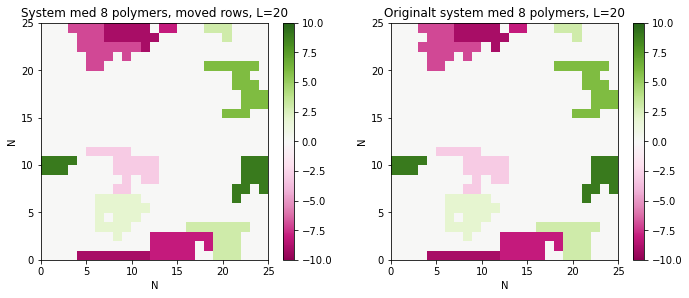

In [44]:

movedPolygrid = medFlex(polygrid, polyval=-7, direction=0, Np=Np, r_or_k='r') #Henter ut system med rad/kolonne flytting

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.pcolormesh(movedPolygrid[::-1,], cmap='PiYG', vmin=-10, vmax=10)     #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"System med {2*Mp} polymers, moved rows, L={L}")

plt.subplot(1,2,2)
plt.pcolormesh(polygrid[::-1,], cmap='PiYG', vmin=-10, vmax=10)          #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"Originalt system med {2*Mp} polymers, L={L}")
plt.tight_layout(2)
plt.show()



Vi kjører to simulasjoner for å analysere differansen mellom dem. Den ene simulasjonen er det originale systemet vi fant tidligere, mens det andre er systemet etter et godkjent fleksibelt flytt. Vi ser tydelig at vår valgte polymer (rosa øverst til venstre) har flyttet for hver rad/kolonne den har kunnet gjøre dette i den retningen vi har ønsket. Utenom dette er systemet slik den originale som den skal. Vi kan da bruke denne koden i Monte Carlo algoritmen og la det skje flere flyttinger. Igjen er dette avhengig av energi, tilfeldigheter og temperatur. Risikoen med denne typen flytt er at polymerer kan risikere å bli oppdelt. Det må vi se nærmere på.


### Oppdelte polymerer

In [45]:

def samePolymer(checkBrokenGrid,centerPoint, polyval, polyLength, N):        #Sjekker om punktet er en del av samme polymer
    checkBrokenGrid[centerPoint[0]][centerPoint[1]] = polyval+100        
                                                    #Setter ny polymerverdi mye høyere slik at den ikke itereres på nytt

    polyLength += 1                                                               #Legger til 1, til polymerlengden
    centerNeighbors = neighbour_coordinates(N, centerPoint[0], centerPoint[1])    #Finner naboer
    length = len(centerNeighbors)
    for d in range(length):
        if checkBrokenGrid[centerNeighbors[d][0]][centerNeighbors[d][1]] == polyval:
            checkBrokenGrid, polyLength = samePolymer(checkBrokenGrid,centerNeighbors[d], polyval, polyLength, N)
    
    return checkBrokenGrid, polyLength


def checkBrokenPolymer(orgGrid, Mediumgrid, L, N):
    checkBrokenGrid = Mediumgrid.copy()                                   #lager kopi av Mediumgrid
    polyValues = list(set(i for j in Mediumgrid for i in j))              #liste med alle unike verdier i polymeren
    polyValues.pop(0)                                   #fjerner nullverdien i listen, da det er "ingen" polymerverdi der
    
    for polyval in polyValues:                                            #iterere for hver polymerverdi
        polyCoord = np.argwhere(Mediumgrid==polyval)                      #Koordinatene for et polymer
        centerPoint = polyCoord[0]                                        #Punktet vi starter å sjekke polymerlengden
        polyLength = 0                                                    #Lengde på polymeren
        checkBrokenGrid, polyLength = samePolymer(checkBrokenGrid, centerPoint, polyval, polyLength, N) 
                                                                          #Returnerer polymerlengden
        if polyLength == L:         #Hvis polymerlengden er den samme som mulitvalens, da er polymeren hel og ikke ødelagt
            continue
        elif polyLength != L:       #Hvis polymerlengden er ulik, vil det implisere at polymeren er oppstykket
            return orgGrid 
    
    return Mediumgrid


Risikoen med vår mer fleksible metode for å flytte et polymer er at flytte av en rad/kolonne og ikke den/de ved siden av kan resultere i at ikke hele polymeren er sammenhengende etter gjennomført flytt. Dette er svært uheldig i og med at vi har bestemt hvor mange polymere vi vil ha og et brudd vil resultere i en ekstra polymer og de begge blir av feil størrelse. 

Vi lager derfor en metode for å sjekke om et slikt brudd har skjedd ved å telle antall clusters og sjekke om vi har like mange før og etter et flytt. Er dette antallet ulikt betyr det at et polymer har blitt delt opp til to eller flere. Om dette har skjedd ønsker vi ikke at systemet skal være slik så vi går tilbake til systemet før flyttet. Er derimot antall polymere likt før og etter flyttet har det ikke skjedd et brudd og flyttet var godkjent slik at vi går videre med det nye systemet.


### Resultater Monte Carlo polynomer

In [46]:

def MC_polygrid(grid, N, M, L, N_s, T, move):             #grid må være med polymerer 
 
    E_total = totalEnergyPolymer(grid)                    #Henter ut total energi til grid

    epsilon = np.zeros(N_s + 1)                           #Lager en tom array som skal fylles med energiverdier
    epsilon[0] = E_total                                  #Første element skal være gridens startenergi

    steps = 0                                             #Bruker antall steg for å stoppe while løkke
    k = 1                                                 #k'te elementet i epsilon 
    positions = np.argwhere(grid)                         #Henter posisjoner til alle monomerer 
    newGrid = grid.copy()                                 #kopierer grid slik at alle flytt skjer i kopien

    while (steps < N_s):                                  #While løkke som stopper når vi når antall steg 
      
        positions = np.argwhere(newGrid)                  #Henter posisjonene til monomerene i polymerene
        random = np.random.randint(len(positions))        
        the_one = positions[random]                       #Velger en av disse posisjonene
        polymer = grid[the_one[0], the_one[1]]            #Henter verdien i denne posisjonen
         
        random_direction = np.random.randint(0,3)         #Velger en tilfeldig retning
        
        if move == "rigid":         #Dersom vi prøver å kjøre rigid move får vi ut grid hvor det er forsøkt 
            newGrid = rigid_move(polymer, random_direction, newGrid, N)
            
        elif move == "medium_flexibility_move":     
                                    #Dersom vi prøver å kjøre medium flexibility move får vi et et grid hvor det er forsøkt 
            if random_direction == 0 or random_direction == 1:
                r_or_k = "r"
            else:
                r_or_k = "k"
            newGrid = medFlex(grid, polymer, random_direction, N, r_or_k)
            riktigGrid = checkBrokenPolymer(grid, newGrid, L, N)
            newGrid = riktigGrid

        p = np.random.random()                           #Får en tilfeldig verdi mellom 0 og 1                           
        steps += 1                                       #Et steg gjennomført, øker steps
       
        new_E_total = totalEnergyPolymer(newGrid)        #Henter ut energi til grid etter forsøkt flytt
        
        
        if new_E_total < E_total:          #Hvis flyttingen gir lavere energi er den tillatt og griden blir den nye riktige
            grid = newGrid.copy()
            E_total = new_E_total
                    
        elif p < np.exp(-betaT(T)*(new_E_total - E_total)):  #Også en sannsynlighet for tillat flytting om dette er oppfylt
            grid = newGrid.copy()
            E_total = new_E_total
                
        epsilon[k] = E_total    #Energi lagt til i epsilon. Dersom ingen endring er det energien fra forrige flytt/start
        k += 1                  #k øker 
            
    return epsilon, grid, newGrid                 


I Monte Carlo algoritmen skal vi endre vårt originale system ved å flytte polymerer. Vi kopierer vårt originale system for å ha en å jobbe med og en som holder seg konstant. Vi lager en liste, epsilon, som skal inneholde alle energiverdier for hvert delsteg av flyttingene. Vår første energi er selvsagt energien fra det originale systemet og så skal vi flytte N_ss ganger. N_ss er en valgfri variabel, men det er ønskelig at den er stor slik at polymerene får flyttet seg nok til å muligens finne en stabil tilstand og plassering. 

Vi finner alle posisjonene til polymerene og velger en tilfeldig av disse som vi skal prøve å flytte en tilfeldig retning. Hvis vi ønsker å flytte polymeren som et stivt legeme forsøker den å gjøre dette ved metoden vi lagde tidligere. Hvis vi derimot ønsker å prøve å flytte polymeren mer fleksibelt gjør vi heller dette med vår metode for dette. Vi velger rad eller kolonne ut fra hvilken tilfeldig retning vi skal flytte. Var det ledig plass i den tilfeldige retningen gjøres flyttet og vi regner ut den nye energien for dette nye systemet. Er denne energiverdien lavere enn den forrige er flyttet gyldig og det nye systemet og energien gjøres til de riktige. 

Vi har også unntak der et flytt er godkjent selv om den nye energien ikke er lavere enn forrige. Dette flyttet blir kun akseptert dersom et tilfeldig tall er mindre enn Boltzmann faktoren med hensyn på energidifferansen. Dermed vil høyere temperaturer gi en større sannsynlighet for et flytt selv om det ikke gir totalt lavere energi. Dette unntaket er grunnet termiske fluktuasjoner og er noe opp til tilfeldighetene, men alltid avhengig av temperaturen til systemet. Vi ønsker da å se hvordan temperatur kan påvirke hvordan systemet ender opp med å se ut til slutt. Når et flytt har vært gyldig blir den nye energien lagt til i epsilon. Vi velger oss ut en ny tilfeldig polymer for å prøve å flytte denne og repeterer hele prosessen til N_ss forsøk på flytt er gjennomført med enten rigid eller medium_flexibility_move.


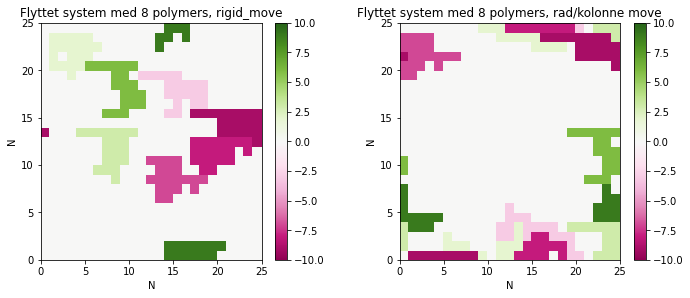

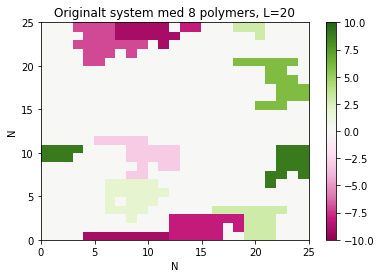

In [88]:
epsilonSL, gridSL, newGridSL = MC_polygrid(polygrid, Np, Mp, L, N_ss, T, "rigid")                    #Henter fra rigid_move
epsilonRK, gridRK, newGridRK = MC_polygrid(polygrid, Np, Mp, L, N_ss, T, "medium_flexibility_move")  #Henter fra medium move

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.pcolormesh(newGridSL[::-1,], cmap='PiYG', vmin=-10, vmax=10)         #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"Flyttet system med {2*Mp} polymers, rigid_move")

plt.subplot(1,2,2)
plt.pcolormesh(newGridRK[::-1,], cmap='PiYG', vmin=-10, vmax=10)         #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"Flyttet system med {2*Mp} polymers, rad/kolonne move")
plt.tight_layout(2)
plt.show()

plt.figure(15)
plt.pcolormesh(polygrid[::-1,], cmap='PiYG', vmin=-10, vmax=10)          #Vi gir ulik farge til pos og neg monomers
plt.colorbar()                                                           #For beskrivelse av hvilke som er pos og neg
plt.xlabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.ylabel("N")                                                          #Tydelig hvilken størrelse på grid (N)
plt.title(f"Originalt system med {2*Mp} polymers, L={L}")
plt.show()
 

Her velger vi å sammenligne det originale systemet med de to ulike måtene å la polymerer flytte seg på. Vi ser tydelig at de to ulike metodene for flytting av polymerer gir svært ulike resultater. Ved rigid_move flytter polymerene som stive legemer og mister aldri sin form selv ved 30 000 runder med mulig flytting i Monte Carlo algoritmen. Ved medium fleksibilitet, altså flytting av rader og kolonner hver for seg, blir uviklingen ulik. Her endrer polymerene form, men holder seg alltid i kontakt med seg selv uten å bli oppdelte.


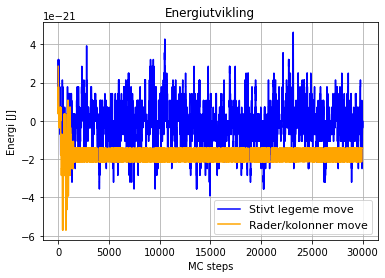

In [87]:

MC_steps = np.arange(0, N_ss+1, 1)                               #Lager en stegsliste for plotting av energiutvikling

plt.figure(7)                       
plt.plot(MC_steps, epsilonSL, label=f"Stivt legeme move", color="Blue")            #Plotter for Stivt legeme move
plt.plot(MC_steps, epsilonRK, label=f"Rader/kolonner move", color = "Orange")      #Plotter for rader/kolonner move
plt.title("Energiutvikling")                                                       #Tittel
plt.ylabel("Energi [J]")                                                           #Navn vertikal akse
plt.xlabel("MC steps")                                                             #Navn horisontal akse
plt.grid()                                                                         #Lager koordinatsystem
plt.legend(fontsize=11)                                        #For å se hvilken utvikling for hvilken flyttemetode
plt.show()


Energiutviklingen til Monte Carlo algoritmen for rigid_move er veldig varierende. Å holde formen til polymerene som et stivt legeme kan hindre den fra å finne gode plasseringer og dermed ikke få lave energier i systemet. Det er også verdt å notere seg at energiverdiene er lave i forholdt til analysen med monomerene.

Energiutviklingen for den andre måten å flytte polymerene på lar energien synke og holde seg ved lavere verdier enn den blå grafen. Når polymerene har mulighet til å flytte radene og kolonnene sine hver for seg kan polymerene klare å komme tettere inntil andre polymerer. Da får vi flere kontakter mellom ulike ladninger, som bidrar til lavere total energi i systemet.


### Clusters av ulike polymerstørrelser

In [74]:

T3 = 300                                 #Temperatur
t_r_p = 1000                             #Konstant og med i formelen for T_equil
N_h = 30                                 #Ønsket valg for størrelse på systemet
M_h = 5                                  #Ønsket valg for antall polymerer, både positive og negative
t_max_p = 10000                          #Konstant og med i formelen for T_equil, kan endres
s_p = 1/200                              #Konstant og med i formelen for T_equil
C_p = 10000                              #Konstant og med i formelen for T_equil
n_p = 10                                 #Antall målinger gjort etter nådd likevekt i systemet, kan endres
t_equil = 20000                          #Valgfri verdi for Nss

L_vals1 = np.linspace(3, 39, 13)
L_vals =[]
for i in range(len(L_vals1)):
    L_vals.append(int(L_vals1[i]))



Det er ønskelig å ha konstantene slik de er valgt her for gode resultater. Vi har lagt ved kommentar om hvilke variabler som kan endres, og dette gjelder kun t_max_p, n_p og t_equil for disse inngår i utrykket for Nss som da er antall ganger Monte Carlo skal kjøres. Valgene av disse verdiene er da relatert til nøyaktighet og kjøretid.

In [75]:

def T_equil_poly(T):                                      #Funksjon som returnerer antall tidssteg før systemet når  
    return (t_max_p*np.e**(-s_p*(T)))+ C_p                #likevekt. Likning fra oppgavetekster


def Nss():                                                 #Funksjon som returnerer antall tidssteg i gitt temperatur T
    return t_equil+ (t_r_p * n_p)  #Likning fra oppgavetekster



def find_clustersize_poly(cluster, clus_val):                  #Funksjon som returnerer størrelsen på et cluster
    number = np.count_nonzero(cluster==clus_val)               #Numpy funksjon som teller antall hvor mange plasser 
    return number                                              #polymerverdien befinner seg 


def mean_clustersize(cluster): #finner gjennomsnittlig størrelse av polymerene i en torus
    lst = []
    d_len = 0
    for i in range(len(cluster)**2):
        clus_size = find_clustersize(cluster, i)                 #Bruker kode fra cluster og monomerer
        if clus_size != 0:
            d_len += 1
        lst.append(clus_size)
    
    #d_sum = np.sum(lst)
    d_sum = 0
    for i in range(len(lst)):
        d_sum += lst[i]
    d_mean = d_sum / d_len

    antallClust = len(lst)
    
    return d_mean, antallClust


def poly_size(grid, N, M, L_vals, T, N_ss, move): #regner ut mean_d / L for alle ulike L verdier
    d_poly = np.zeros(len(grid))
    m = np.zeros(len(grid))
    
    for v in range(len(L_vals)):
        L = L_vals[v]
        N_poly = Nss()
        epsilonPoly, gridPoly, newGridPoly = MC_polygrid(polygrid, Np, Mp, L, N_poly, T, move)
        d_mean, antallClust = mean_clustersize(newGridPoly)
        d_poly[v] = d_mean / L
        m[v] = antallClust / L
    
    #d_poly_riktig = d_poly[~np.all(d_poly == 0, axis=0)]
    d_poly_riktig = d_poly[:13]
    m = m.ravel()[np.flatnonzero(m)]
    
    return d_poly_riktig, m



Vi finner størrelsen til hver cluster, d, og tar et gjennomsnitt av dette for hver L-verdi og lager en liste av dette. Disse verdiene deler vi igjen på L for å få et tall på hvor mange polymere som har gruppert seg sammen og ikke antall monomerer som polymerene er bygd opp av. Dette skal vi senere plotte som en funksjon av L.

Vi finner også gjennomsnitlig antall clusters. Er grupperingene store, altså d, vil antallet være lavt. Er grupperingene små derimot vil det være flere clusters slik at dette vil være en verdi som varierer motsatt av d/L.


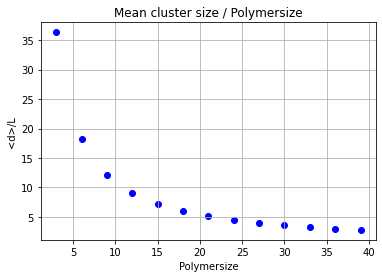

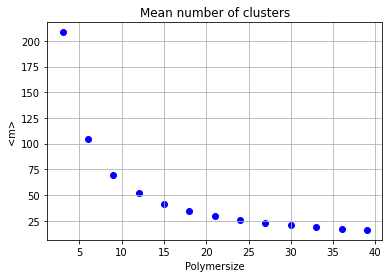

In [76]:

d_poly, m = poly_size(polygrid, N_h, M_h, L_vals, T3, N_ss, "rigid")
#Henter ut clusterstørrelse per polystørrelse og antall clusters

plt.figure(8)                                
plt.scatter(L_vals, d_poly, color="Blue")                 #Lager et punktplott over clusterstørrelse per polystørrelse
plt.ylabel("<d>/L")                                       #Navn på vertikalakse
plt.xlabel("Polymersize")                                 #Navn på horisontalakse
plt.title("Mean cluster size / Polymersize")              #Tittel
plt.grid()                                                #Rutenett
plt.show()

plt.figure(9)                                
plt.scatter(L_vals, m, color="Blue")                     #Lager et punktplott over antall clusters for ulike startparametre
plt.ylabel("<m>")                                        #Navn på vertikalakse
plt.xlabel("Polymersize")                                #Navn på horisontalakse
plt.title("Mean number of clusters")                     #Tittel
plt.grid()                                               #Rutenett
plt.show()


Plottet vi får for d/L, altså gjennomsnittlig størrelse på clusters delt på størrelse på hver polymer, gir oss en oversikt over hvor mange polymerer som grupperer seg sammen. 

Vi valgte t_equil og n slik at N_ss ble 30 000, altså et tall på antall kjøringer som har fungert godt for oss før. 

Vi forventet at om d/L går gradvis ned og stagnerer så burde m gå gradvis opp og stagnere. Om grupperingene er store burde de være få i antall, mens om grupperingene er små burde det være flere av dem. 

Vi forventer at resultatene vil variere mest ved lave L fordi da blir det større tomrom i systemet og mer variasjonsmulighet for hvor store grupperingene av polymerer blir. 

Om vi endrer alpha i systemet vårt ved å f.eks. endre pH som da endrer e_r vil vi kunne få andre resultater. Da blir det ikke like mye tiltrekning mellom polymerene som er intill hverandre. Da blir energiverdiene ulike og det kan gi store endringer i Monte Carlo algoritmen og utviklingen av systemet. Vi kan endre pH og e_r til både større og mindre. Ved større vil energiverdi bli mindre og det blir mindre tiltrekning. Vi prøvde dette for systemene og det ble betydningsfullt færre grupperinger, uansett temperatur. Ved mindre pH vil energinivåene bli større og det blir mer tiltrekning. Vi prøvde også dette for systemene og da ble grupperingene like i antall og størrelse uavhengig av temperaturer i systemene. 


### Konklusjon 

Monomerer av ulik ladning vil flytte seg mot hverandre for å senke energien i systemet de er en del av. Ved lave temperaturer resulterer dette i grupperinger av monomerer som er systematisert plassert som gitter. Annenhver positiv og negativ verdi lik slik vi ser ioner i salter som f.eks. Natriumklorid. Dette gir oss energierverdier som er lave og relativt stabile. 
Høyere temperaturer gir oftere opphav for termiske fluktuasjoner slik at monomerene kan bevege seg vekk fra stabile strukturer og gi et mer tilfeldig system som resultat. Dette gir mer varierene energier og aldri særlig lave verdier. 

Polymerer er mer avanserte elementer, og består av flere monomerer. Det er opp til oss hvordan de skal få lov til å fungere. De har på lik linje med monomerer ulike ladninger og vil flytte mot hverandre for å senke energien slik som monomerene gjorde ved lave temperaturer. 

Polymerer vil ofte få sine forsøk på flyttinger stoppet fordi det enten står noe i veien eller en polymer blir brutt. Ved bruk av medium flexibility move kan man se at energien vil bli noe lavere enn ved bruk av rigid move. Dette fordi ved medium flexibility move kan polymeren endre form slik at den lettere kan flytte til posisjoner som gir en lavere total energi. Ved rigid move oppfører polymeren seg som et stivt legeme, og vil dermed ikke ha alle mulighetene for flytt som den har ved medium flexibility move. 

